In [35]:
import pandas as pd
import uproot3 as up3
import numpy as np
import os
import matplotlib.pyplot as plt

In [38]:
chi_type = ["scalar", "fermion"]
csv_dict = []
for chi in chi_type:
    for f in os.listdir(f"../data/root/BdNMC/{chi}"):
        # look for corresponding .out file
        path_to_condor_out = f"../data/condor_out/node_{f.strip('.root')}.out"
        
        if os.path.exists(path_to_condor_out):
            with open(path_to_condor_out) as out_file:
                out = out_file.readlines()
                for line in out:
                    if "Predicted number of signal events =" in line:
                        n_events = float(line.split("=")[-1])
                        #print(n_events)
                    
                    if "Maximum event probability" in line:
                        pmax = float(line.split("=")[-1])
                        #print(pmax)
                
            
            with up3.open(f"../data/root/BdNMC/{chi}/{f}") as rootf:
                pot = rootf["pot_tree"]["tot_pot"].array()[0]
                nelectons = rootf["elecron_tree"].numentries

            meson, ct, _, ma, _, dt = f.strip(".root").split("_")
            csv_dict.append([ct, meson, dt, ma, n_events, pmax, pot, nelectons])


In [39]:
# chi_type // meson // dt // ma // n_events // pmax // pot // nelectrons
df = pd.DataFrame(csv_dict, columns=["ct", "meson", "dt", "ma", "n_events", "pmax", "pot", "nelectrons"])
df["n_events"] = df["n_events"].astype(float)
df["pmax"] = df["pmax"].astype(float)
df["pot"] = df["pot"].astype(float)
df["nelectrons"] = df["nelectrons"].astype(float)
df["ma"] = df["ma"].astype(float)
df.to_csv("../data/csv/BdNMC_pmax_and_nevents.csv", index=False)
df.head()

,ct,meson,dt,ma,n_events,pmax,pot,nelectrons
0,scalar,pi0,0.6,0.01,14961.000000,5.430760e-05,2.254201e+15,621.0
1,scalar,pi0,0.33,0.03,56312.700000,2.636770e-06,1.760572e+13,376.0
2,scalar,eta,2.0,0.04,0.076085,2.834880e-08,3.684334e+17,989.0
3,scalar,eta,2.0,0.09,0.000017,9.959000e-10,2.753466e+19,460.0
4,scalar,eta,0.33,0.40,0.000906,5.139570e-12,3.063976e+15,540.0


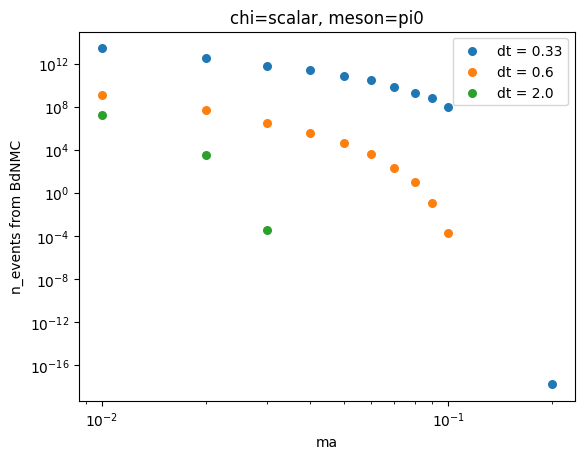

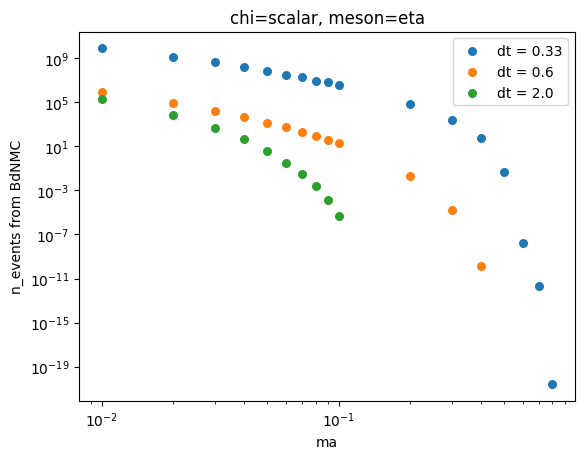

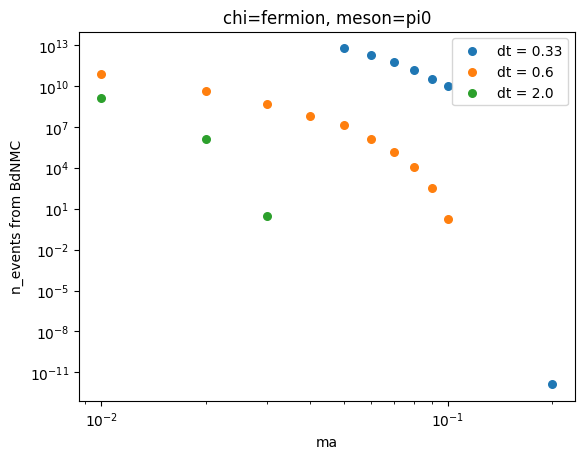

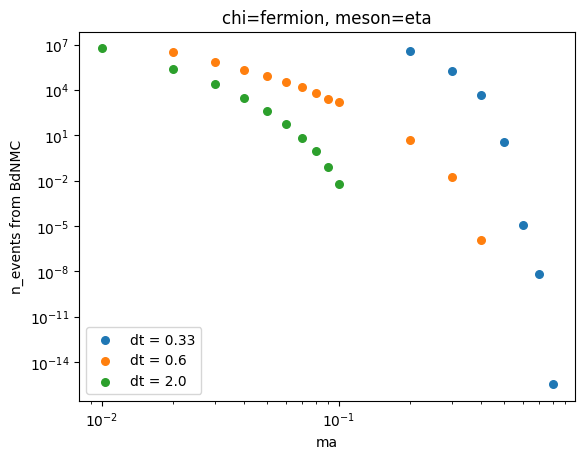

In [64]:
dts = [0.33, 0.6, 2.0]
chi_types = ["scalar", "fermion"]
mesons = ["pi0", "eta"]

for chi in chi_types:
    for m in mesons:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        for dt in dts:
            df_ = df[(df["ct"] == chi) & (df["meson"] == m) & (df["dt"] == str(dt))]
            ax.scatter(df_["ma"], df_["n_events"] * 2e20 / df_["pot"], label=f"dt = {dt}", s=30)


        ax.set(title=f"chi={chi}, meson={m}", xlabel="ma", ylabel="n_events from BdNMC")

        ax.legend()
        ax.loglog()
        plt.show()
# doesnt take into account anything from microboon, bad

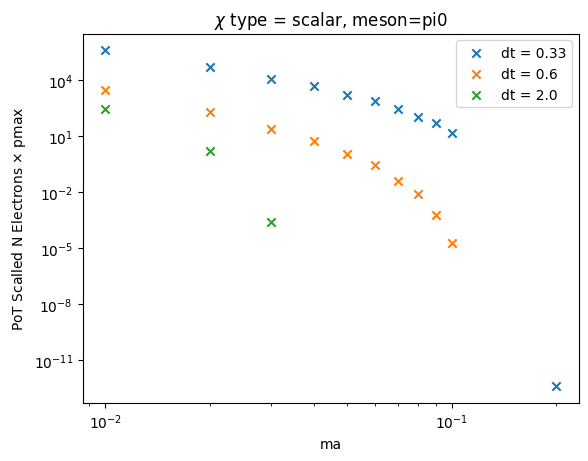

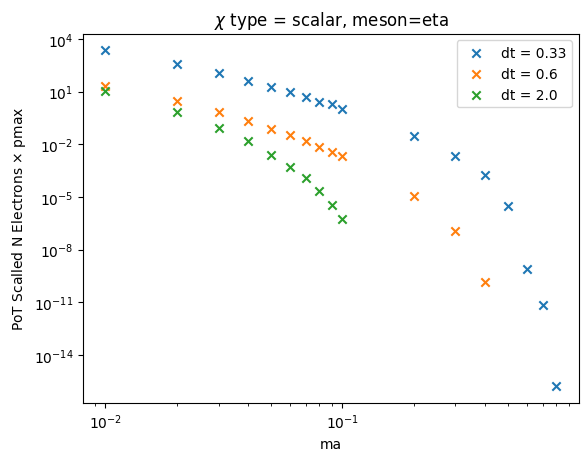

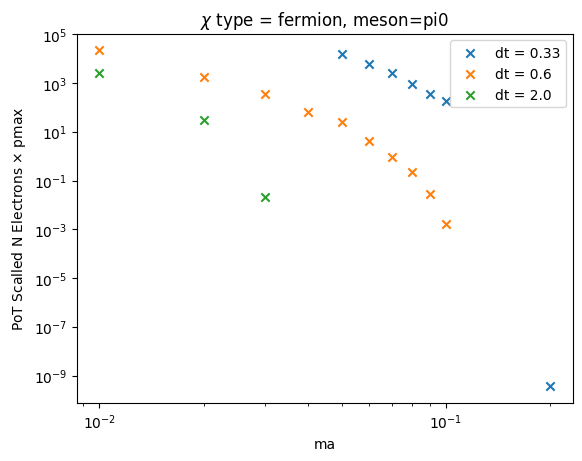

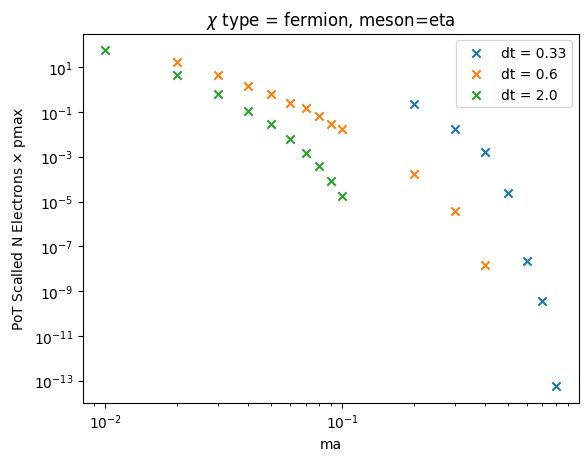

In [61]:
POT_run1_microboone = 2e20 # From online i found run 1 to be 2e20 and 1.9e20 and 2.2e20
import sys
sys.path.append("../")
from src.PoT_scalling import pot_scale

for chi in chi_types:
    for m in mesons:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        for dt in dts:
            df_ = df[(df["ct"] == chi) & (df["meson"] == m) & (df["dt"] == str(dt))]
            n_electrons_pot_scaled = pot_scale(df_["nelectrons"], df_["pot"], POT_run1_microboone) * df_["pmax"]
            ax.scatter(df_["ma"], n_electrons_pot_scaled, label=f"dt = {dt}", marker="x")


        ax.set(title=r"$\chi$ type = "+f"{chi}, meson={m}", xlabel="ma", ylabel=r"PoT Scalled N Electrons $\times$ pmax")

        ax.legend()
        ax.loglog()
        fig.savefig(f"../plots/PoT/pmax_and_nelectrons_{m}_{chi}.png")
        plt.show()